In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

## Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/ SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [2]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv", encoding = 'unicode_escape').drop(['Date', 'Seasons', 'Holiday'], axis=1)
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [3]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,1
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,1
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,1
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,1


In [4]:
# use dataset hour equal 12
df = df[df["hour"] == 12]
df = df.drop(['hour'],axis=1)
df

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
8652,752,9.1,57,1.1,562,1.0,1.69,0.0,0.0,1
8676,672,9.3,61,1.5,390,2.1,0.85,0.0,0.0,1
8700,635,7.9,14,1.7,1688,-18.0,1.81,0.0,0.0,1
8724,661,5.6,27,0.3,1522,-11.9,0.34,0.0,0.0,1


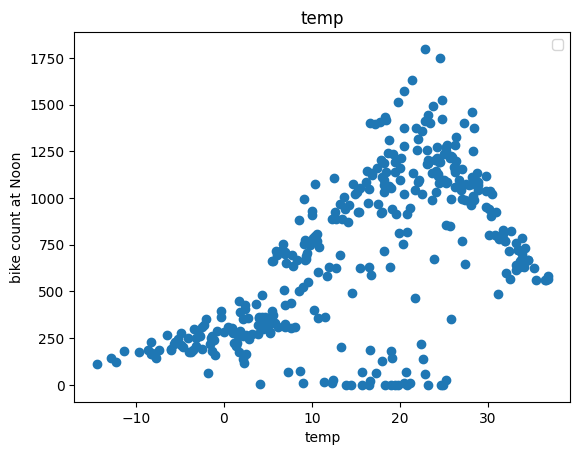

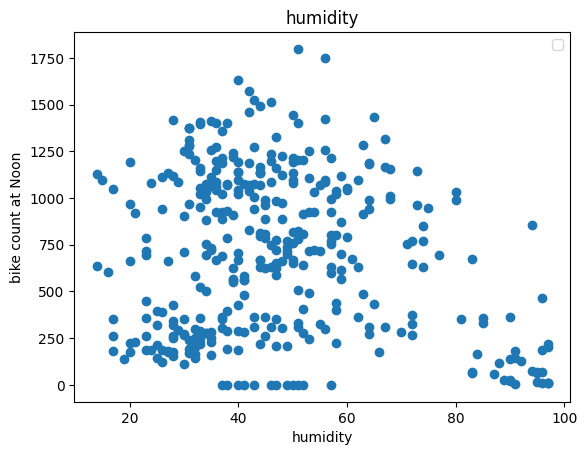

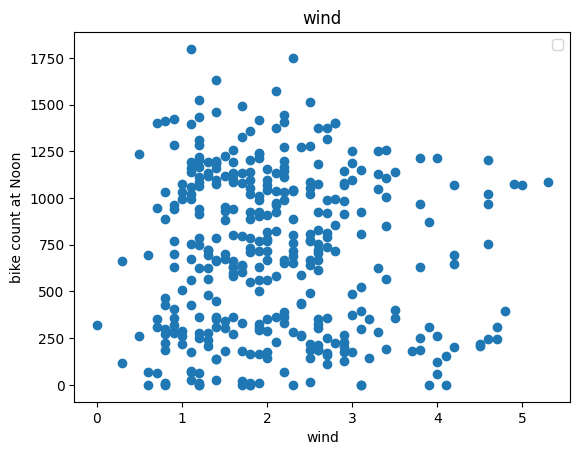

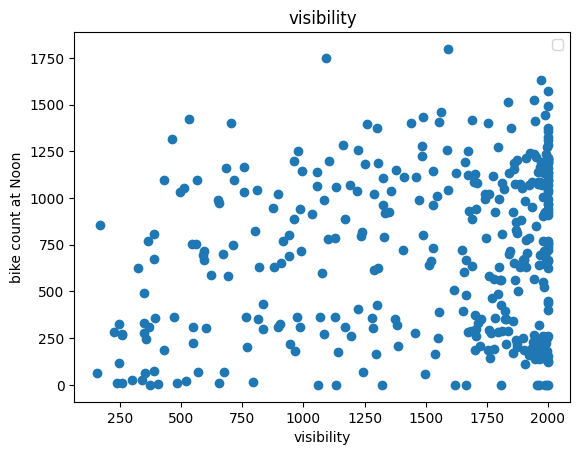

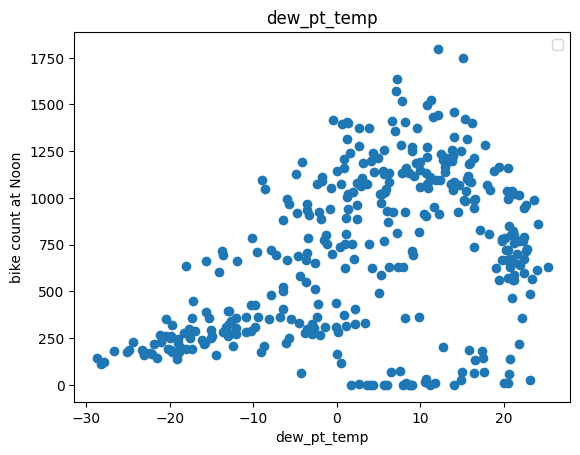

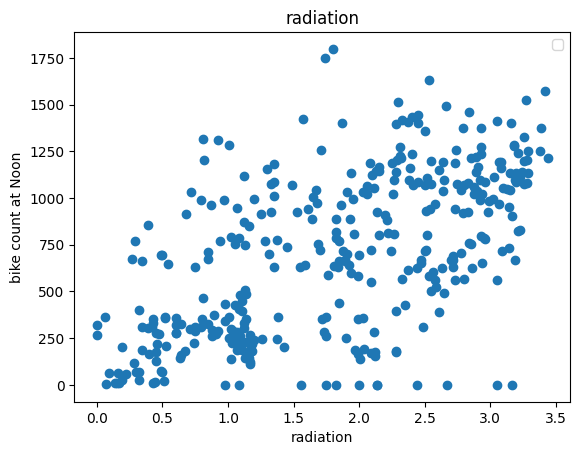

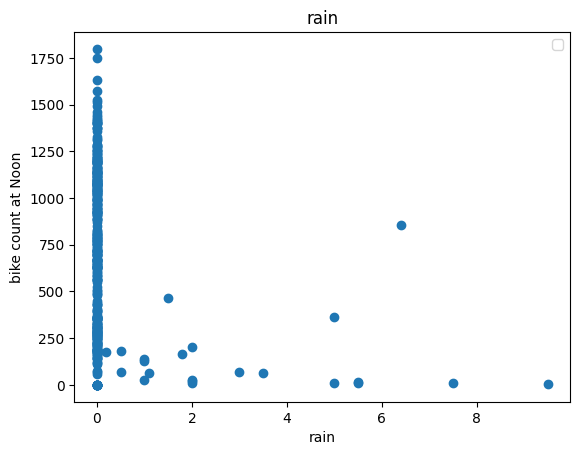

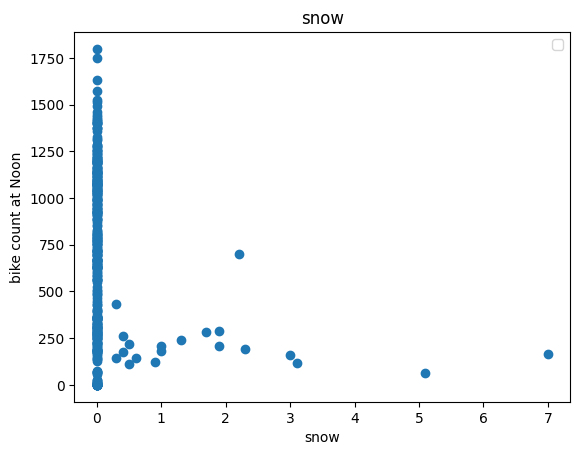

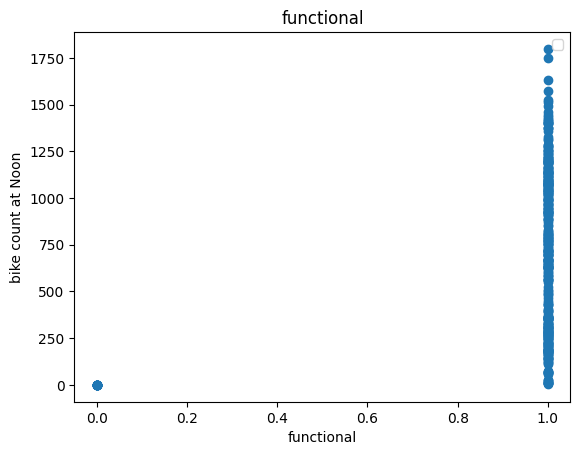

In [5]:
# bike_count compared with other cols
for i in df.columns[1:]:
  plt.scatter(df[i],df['bike_count'])
  plt.title(i)
  plt.ylabel("bike count at Noon")
  plt.xlabel(i)
  plt.legend()
  plt.show()

In [6]:
df = df.drop(["wind","visibility","functional"], axis =1 )

In [7]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


Train/ Valid/ Test

In [8]:
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [9]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [10]:
_, X_train_temp , y_train_temp = get_xy(train,"bike_count", x_labels = ['temp'])
_, X_valid_temp , y_valid_temp = get_xy(valid,"bike_count", x_labels = ['temp'])
_, X_test_temp , y_test_temp = get_xy(test,"bike_count", x_labels = ['temp'])


In [11]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [12]:
print(temp_reg.coef_,temp_reg.intercept_)

[[18.3873703]] [401.23963695]


In [13]:
print(temp_reg.score(X_train_temp, y_train_temp))
# hiệu suất đạt được

0.2613478249116288


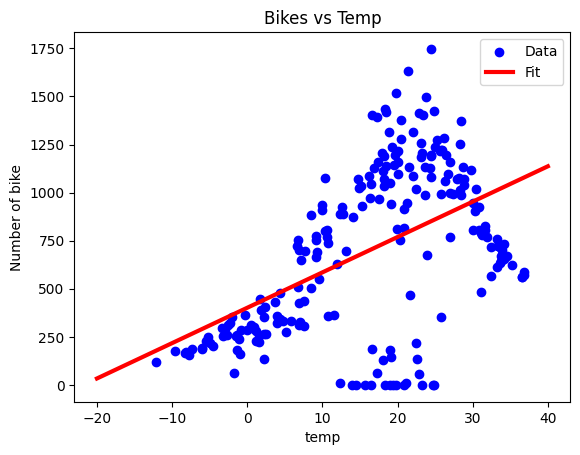

In [14]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color ="blue")
x = tf.linspace(-20,40,100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label = "Fit",
         color="red" ,linewidth =3)
plt.title("Bikes vs Temp")
plt.ylabel("Number of bike")
plt.xlabel("temp")
plt.legend()
plt.show()

Example 1:

Hệ số:  [2.5]
Giá trị chặn:  37.49999999999994


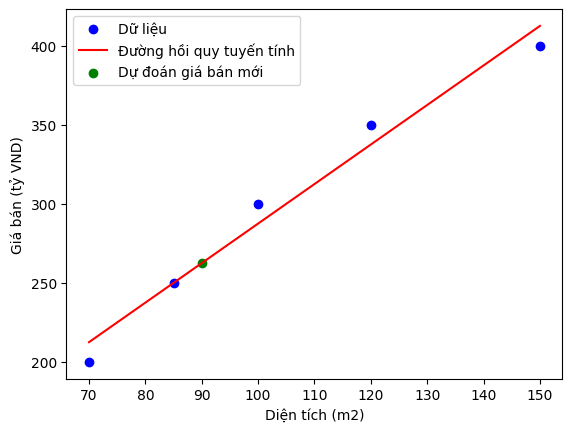

In [15]:
''' Example: (truth)
Giả sử chúng ta có dữ liệu về diện tích căn nhà và giá bán của các căn nhà.
Chúng ta muốn xây dựng một mô hình hồi quy tuyến tính để dự đoán giá bán của một
căn nhà dựa vào diện tích của nó. Trong trường hợp này, diện tích căn nhà là biến độc lập,
và giá bán là biến phụ thuộc.
 '''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Dữ liệu về diện tích căn nhà và giá bán 5 căn in Đa Mặn Đà Nẵng,VN (giả định)
diện_tích = np.array([70, 85, 100, 120, 150])
giá_bán = np.array([200, 250, 300, 350, 400])

# Chuyển đổi thành mảng 2D (cần shape (-1, 1))
X = diện_tích.reshape(-1, 1)

# Tạo và huấn luyện mô hình hồi quy tuyến tính
regressor = LinearRegression()
regressor.fit(X, giá_bán)

# Dự đoán một diện tích khách hàng BTOM muốn bán (ví dụ: 90m2)
diện_tích_mới = np.array([90]).reshape(-1, 1)
giá_bán_dự_đoán = regressor.predict(diện_tích_mới)


# In ra các hệ số và giá trị chặn
print("Hệ số: ", regressor.coef_)
'''
hệ số cho biết mức tăng hoặc giảm của giá bán (điểm mục tiêu) cho mỗi đơn vị
tăng của biến độc lập (diện tích). Trong trường hợp này, hệ số đại diện cho giá
trị dự đoán tăng bao nhiêu đồng khi diện tích căn nhà tăng lên 1 mét vuông.
'''
print("Giá trị chặn: ", regressor.intercept_)
#giá trị chặn là yếu tố cần thiết trong đường hồi quy tuyến tính để tạo ra một đường thẳng hoặc siêu mặt phẳng,



# Vẽ biểu đồ dữ liệu và đường hồi quy tuyến tính
plt.scatter(diện_tích, giá_bán, color='blue', label='Dữ liệu')
plt.plot(diện_tích, regressor.predict(X), color='red', label='Đường hồi quy tuyến tính')
plt.scatter(diện_tích_mới, giá_bán_dự_đoán, color='green', label='Dự đoán giá bán mới')
plt.xlabel('Diện tích (m2)')
plt.ylabel('Giá bán (tỷ VND)')
plt.legend()
plt.show()


In [16]:
# => diện tích tăng 2.5 đồng/ 1 mét vuông
# => giá nhà dao động 0-37.5 đồng / 1 mét vuông

In [17]:
print(regressor.score(X, giá_bán))
# 97,5% : perfect for this issue

0.975


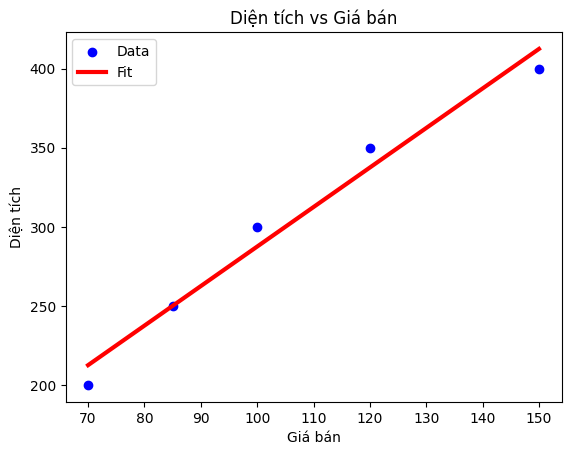

In [18]:
plt.scatter(X, giá_bán, label = "Data", color ="blue")
x = tf.linspace(70,150,100)
plt.plot(x, regressor.predict(np.array(x).reshape(-1,1)), label = "Fit",
         color="red" ,linewidth =3)
plt.title("Diện tích vs Giá bán")
plt.ylabel("Diện tích")
plt.xlabel("Giá bán")
plt.legend()
plt.show()

## Multiple linear regression

In [77]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])


In [78]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [79]:
all_reg.score(X_test_all, y_test_all)

0.5268930011605998

## Regression with Neural Net

In [80]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [81]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [82]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [83]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_valid_temp, y_valid_temp)
)


In [ ]:
plot_loss(history)

2/2 [==============================] - 0s 6ms/step


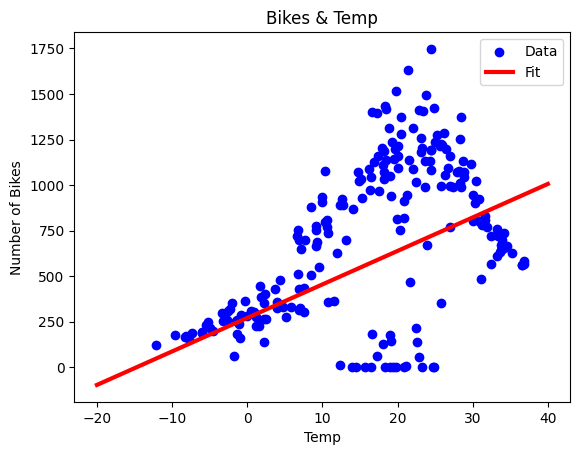

In [29]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color ="blue")
x = tf.linspace(-20,40,40)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label = "Fit",
         color="red" ,linewidth =3)
plt.title("Bikes & Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.legend()
plt.show()

## Neural Net

In [75]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),

    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')


In [76]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    verbose=0,
    epochs=100,
    validation_data=(X_valid_temp, y_valid_temp)
)

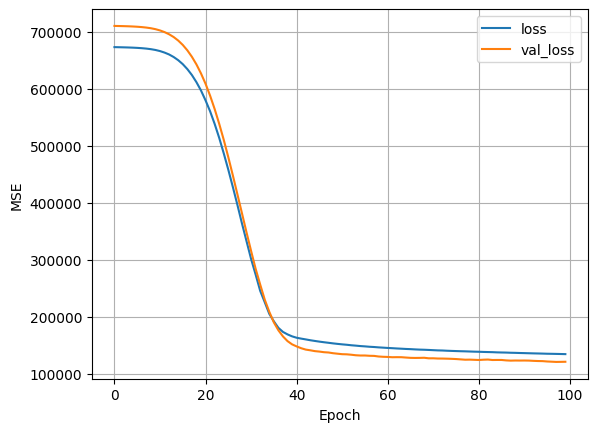

In [39]:
plot_loss(history)

2/2 [==============================] - 0s 9ms/step


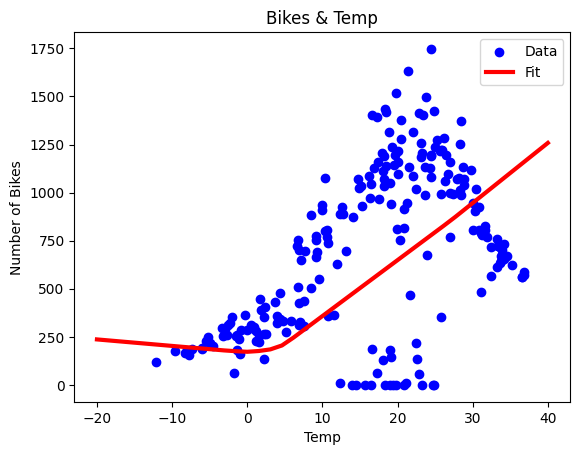

In [36]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color ="blue")
x = tf.linspace(-20,40,40)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label = "Fit",
         color="red" ,linewidth =3)
plt.title("Bikes & Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.legend()
plt.show()

In [61]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=-1)
all_normalizer.adapt(X_train_all)
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')


In [42]:
history = nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=100,
    validation_data=(X_train_all, y_train_all)
)

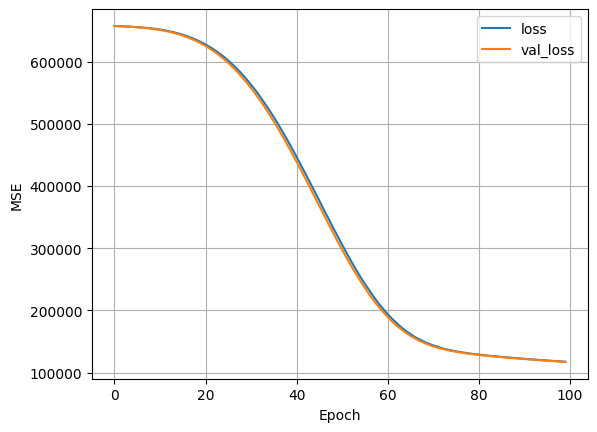

In [43]:
plot_loss(history)

In [62]:
# Calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 7ms/step


In [67]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [50]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving MSE.jpg to MSE (3).jpg


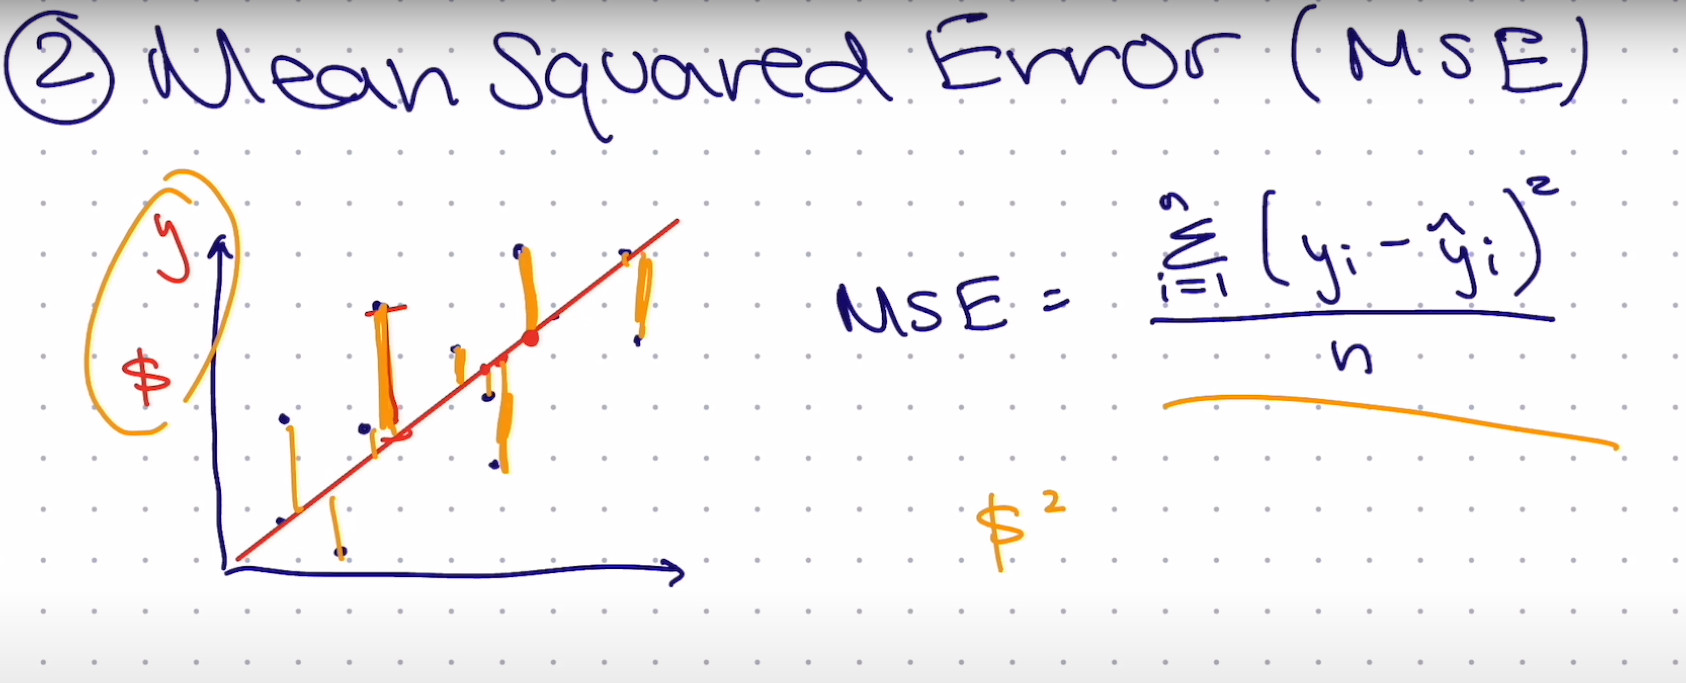

In [54]:
from IPython.display import Image, display
display(Image(filename=image_path))

In [68]:
MSE(y_pred_lr, y_test_all)

299169.01716920896

In [69]:
MSE(y_pred_nn, y_test_all)


680349.4193238398

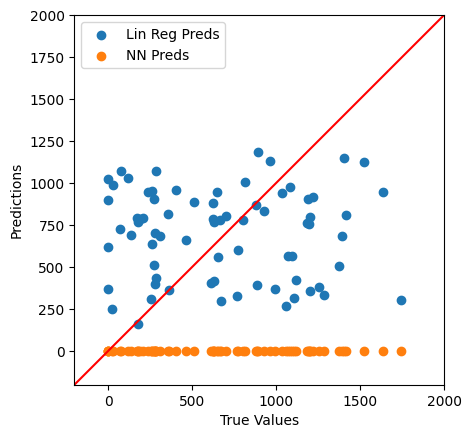

In [74]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [-200, 2000]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")